# Comparison of results for *fluid* system and choice of hyper_params. 

In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
import os

import sys
sys.path.insert(0, '../')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from dmd_functions import *
from tensorflow import keras
import pickle
import numpy as np
from pydmd import DMD
from numpy import matlib

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Step 1: Read in a random test batch. 

In [179]:
tmp = DataMaker(x_lower1=0, x_upper1=1.1, x_lower2=0, x_upper2=2 * np.pi,
                n_ic=25, dt=0.01,
                tf=8, data_type='fluid_flow_slow',
                testing=False, path="../data/validation_fluid")
fluid_data = tf.transpose(tmp.data_val, perm=[0, 1, 2])
print(fluid_data.shape)

(25, 3, 801)


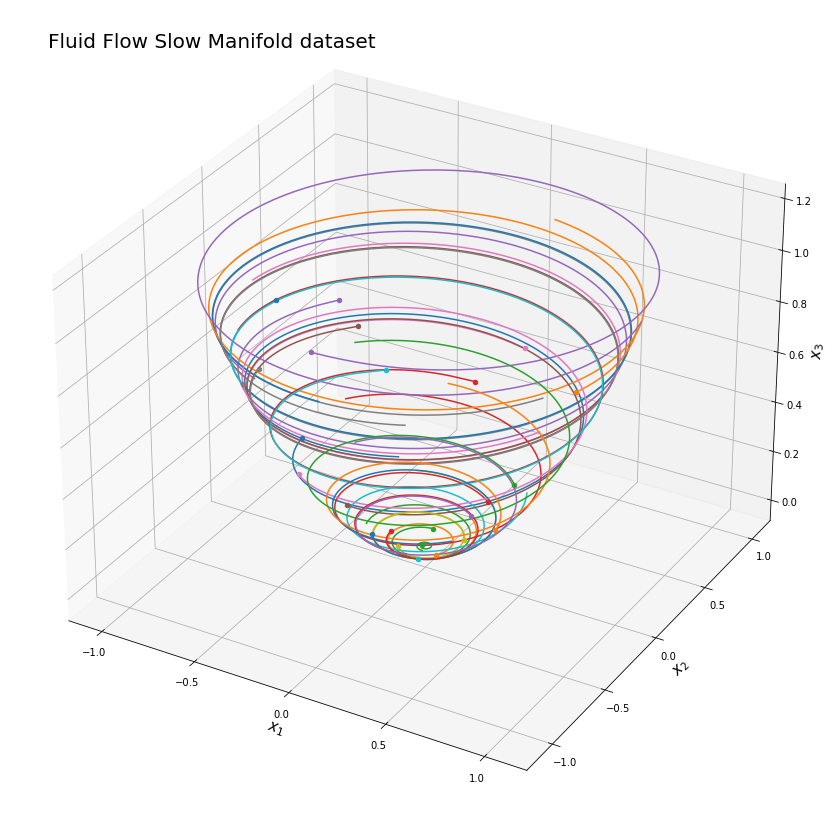

In [180]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, 25):
    ii = int(ii)
    x1 = fluid_data[ii, 0, :]
    x2 = fluid_data[ii, 1, :]
    x3 = fluid_data[ii, 2, :]
    ax.plot3D(x1, x2, x3)
    ax.scatter3D(x1[0], x2[0], x3[0])

ax.set_xlabel("$x_{1}$", fontsize=15)
ax.set_ylabel("$x_{2}$", fontsize=15)
ax.set_zlabel("$x_{3}$", fontsize=15)
ax.text2D(0.05, 0.95, "Fluid Flow Slow Manifold dataset", transform=ax.transAxes, fontsize=20)
# plt.savefig('fluid_flow.png')
plt.show()

# Step 3: Load a saved model. 

In [181]:
hyp_params = dict()
hyp_params['num_t_steps'] = np.shape(fluid_data)[2]
hyp_params['phys_dim'] = 3
hyp_params['num_init_conds'] = np.shape(fluid_data)[0]
hyp_params['batch_size'] = np.shape(fluid_data)[0] # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 500  # MAJOR PARAMETER CHOICE
hyp_params['window_size'] = np.shape(fluid_data)[0] # MAJOR PARAMETER CHOICE

# Encoding/Decoding Layer Parameters.
hyp_params['num_en_layers'] = 3
hyp_params['num_en_neurons'] = 80
hyp_params['latent_dim'] = 2
hyp_params['window_size'] = 256

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['ae_output_activation'] = "linear"
hyp_params['hidden_activation'] = "elu"

hyp_params['c1'] = 10  # coefficient auto-encoder loss.
hyp_params['c2'] = 1  # coefficient of dmd loss.
hyp_params['c3'] = 1  # coefficient of pred loss.

myMachine = DMDMachine(hyp_params)

data_test = fluid_data 

In [182]:
dmd_loss = format(myMachine.get_linearity_loss(tf.convert_to_tensor(data_test)).numpy(), ".3E")
print("DMD Loss on input dataset = " + dmd_loss)
hyp_params['latent_dim'] = 3
myMachine = DMDMachine(hyp_params)
y_pred_reshape =  DMDMachine.compute_predict_batch_reshape(myMachine, y_data_mat=tf.convert_to_tensor(data_test))
print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(data_test), y_pred_reshape)).numpy())

DMD Loss on input dataset = 6.105E-06
Pred Loss on input dataset =  6.533524e-07


In [183]:
# add noise to dataset. 
noisy_data = np.random.normal(-0.005, 0.005, data_test.shape) + data_test 

In [184]:
dmd_loss = format(myMachine.get_linearity_loss(tf.convert_to_tensor(noisy_data)).numpy(), ".3E")
print("DMD Loss on input dataset = " + dmd_loss)
hyp_params['latent_dim'] = 3
myMachine = DMDMachine(hyp_params)
y_pred_reshape =  DMDMachine.compute_predict_batch_reshape(myMachine, y_data_mat=tf.convert_to_tensor(noisy_data))
print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(noisy_data), y_pred_reshape)).numpy())

DMD Loss on input dataset = 1.184E-01
Pred Loss on input dataset =  5.6856057e-05


In [195]:
# Load results from Dec 14th -- latent space dimensions are 2 (instead of 3)! 

hyp_params['latent_dim'] = 2
myMachine = DMDMachine(hyp_params)

myMachine.autoencoder.encoder = keras.models.load_model("../models/2021/fluid/encAeEx3_2021-01-20", compile=False)
myMachine.autoencoder.decoder = keras.models.load_model("../models/2021/fluid/decAeEx3_2021-01-20", compile=False)

In [196]:
test_run = myMachine(data_test)

In [197]:
print("dmd loss machine= " +  format(test_run[2].numpy(), ".3E"))
print("autoencoder loss machine = " + format(test_run[3].numpy(), ".3E"))
print("prediction loss machine = " + format(test_run[5].numpy(), ".3E"))
print("decode predicted reconstruction loss machine = " + format(test_run[7].numpy(), ".3E"))

dmd loss machine= 3.038E-06
autoencoder loss machine = 3.657E-06
prediction loss machine = 8.111E-08
decode predicted reconstruction loss machine = 1.047E-06


# Step 3: Plot results.

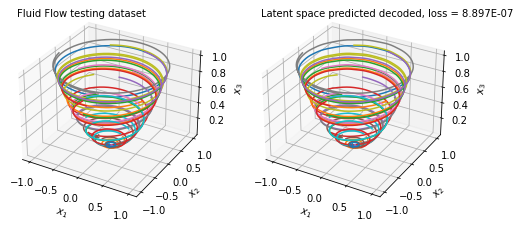

In [137]:
create_plots_fluid_pred(data_test, test_run, hyp_params, 0, "figures", data_type="test", compare_models=True)

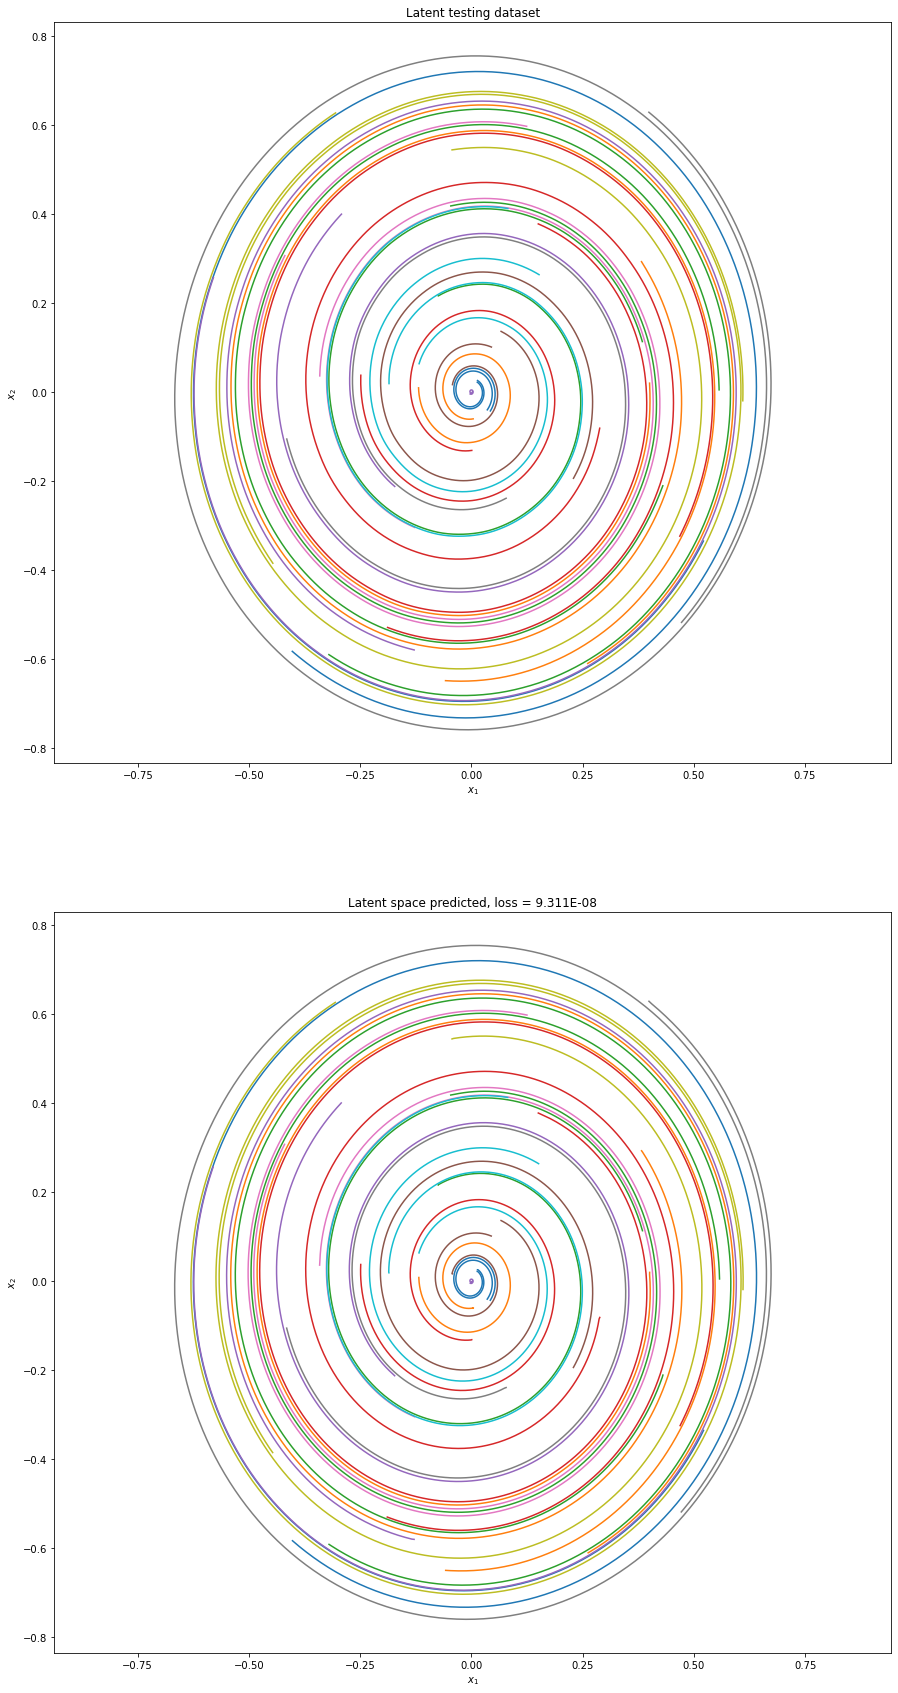

In [138]:
create_plots_fluid_latent_2d(test_run, hyp_params, 0, "figures", data_type="test", compare_models=True)

# Step 5: predict forward in time beyond 1. 


In [139]:
y = test_run[1]
y_reshape = myMachine.reshape(y).numpy()
A = myMachine.get_amat(y_reshape).numpy()

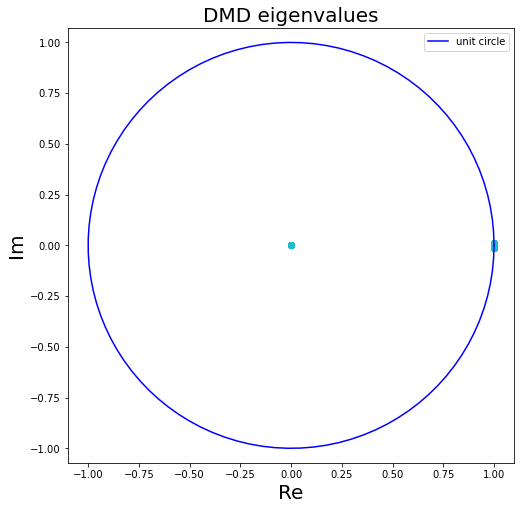

In [140]:
fig, ax = plt.subplots(figsize=(8, 8))

rect = fig.patch
rect.set_facecolor("white")

# plot unit circle.
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(t), np.sin(t), "b", label="unit circle")

# compute the eigenvalues.
w, v = np.linalg.eig(A)

for ii in range(len(w)):
    ax.scatter(w.real, w.imag)

ax.set_title("DMD eigenvalues", fontsize=20)
ax.set_ylabel("Im", fontsize=20)
ax.set_xlabel("Re", fontsize=20)
ax.set_ylim(-1.1, 1.1)
ax.set_xlim(-1.1, 1.1)

plt.axis("equal")
plt.legend()

In [166]:
pred_step = 2100

y_pred = np.zeros((y_reshape.shape[0], pred_step))
y_pred[:, 0] = y_reshape[:, 0]

A_exp = np.identity(A.shape[0])

for ii in range(1, pred_step):
    A_exp = A @ A_exp
    y_pred[:, ii] = A_exp @ y_pred[:, 0]


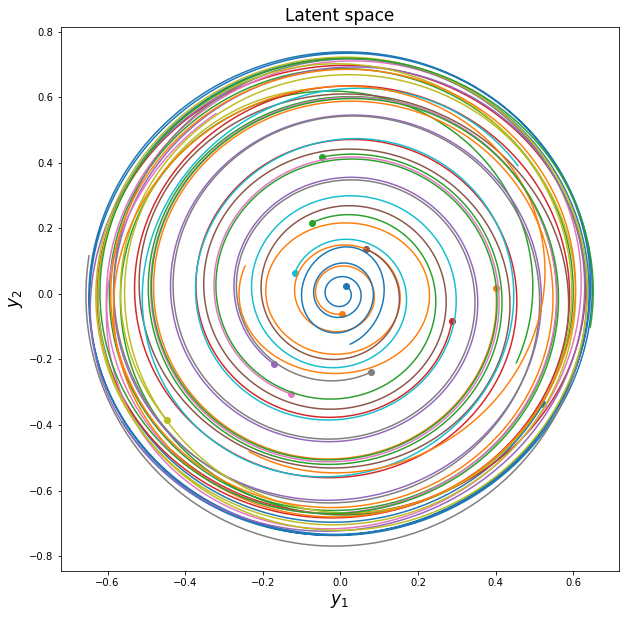

In [167]:
fig, ax = plt.subplots(figsize=(10, 10))
    
rect = fig.patch
rect.set_facecolor("white")
# set up the axes for the first plot
y_pred_mat = np.zeros((15, 2, pred_step))

for ii in range(0, 13):
    x1 = y_pred[2* ii, :]
    x2 = y_pred[2* ii + 1, :]
    y_pred_mat[ii, 0, :] = y_pred[2* ii, :]
    y_pred_mat[ii, 1, :] = y_pred[2* ii + 1, :]
    ax.plot(x1, x2)
    ax.scatter(x1[0], x2[0])
    
r = 2

_ = ax.set_xlabel("$y_{1}$", fontsize=17)
_ = ax.set_ylabel("$y_{2}$", fontsize=17)
_ = ax.set_title("Latent space", fontsize=17)


#plt.savefig("./", facecolor=fig.get_facecolor())

In [168]:
y_pred_dec = myMachine.autoencoder.decode(y_pred_mat)
np.shape(y_pred)

(50, 2100)

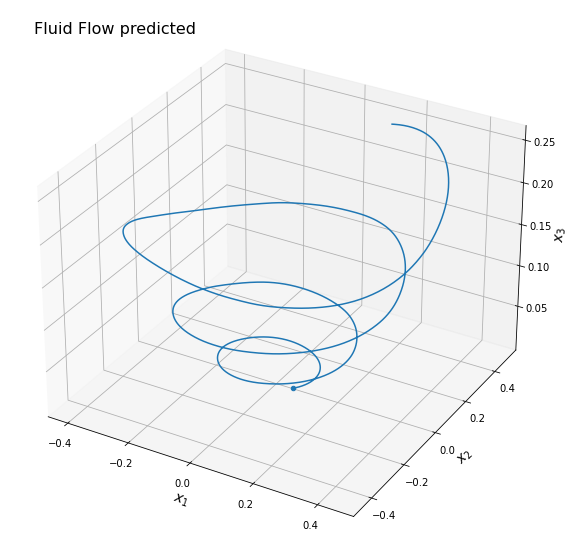

In [172]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(17, 10))

rect = fig.patch
rect.set_facecolor("white")
# set up the axes for the first plot
ax = fig.add_subplot(projection='3d')
for ii in range(1, 2):
    x1 = y_pred_dec[ii, 0, :]
    x2 = y_pred_dec[ii, 1, :]
    x3 = y_pred_dec[ii, 2, :]
    ax.plot3D(x1, x2, x3)
    ax.scatter3D(x1[0], x2[0], x3[0])

ax.set_xlabel("$x_{1}$", fontsize=14)
ax.set_ylabel("$x_{2}$", fontsize=14)
ax.set_zlabel("$x_{3}$", fontsize=14)
_ = ax.text2D(0.05, 0.95, "Fluid Flow predicted", transform=ax.transAxes, fontsize=16)

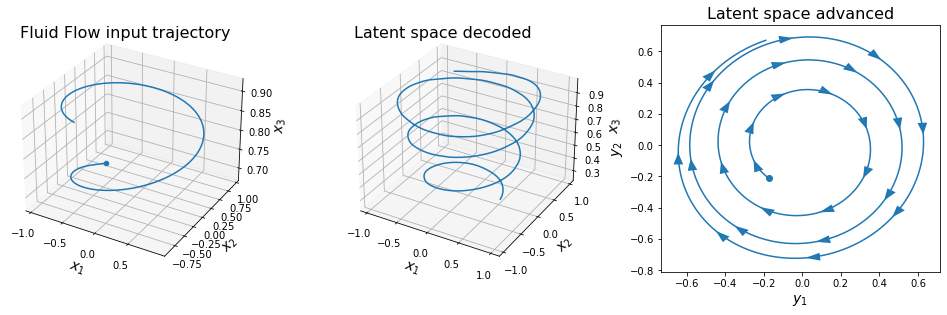

In [198]:
r=4

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(17, 10))

rect = fig.patch
rect.set_facecolor("white")

# set up the axes for the first plot
ax = fig.add_subplot(231, projection='3d')
observed_data = data_test
for ii in range(r, r+1):
    x1 = observed_data[ii, 0, :]
    x2 = observed_data[ii, 1, :]
    x3 = observed_data[ii, 2, :]
    ax.plot3D(x1, x2, x3)
    ax.scatter3D(x1[0], x2[0], x3[0])

ax.set_xlabel("$x_{1}$", fontsize=14)
ax.set_ylabel("$x_{2}$", fontsize=14)
ax.set_zlabel("$x_{3}$", fontsize=14)
ax.text2D(0.05, 0.95, "Fluid Flow input trajectory", transform=ax.transAxes, fontsize=16)


# set up the axes for the second plot
ax = fig.add_subplot(232, projection='3d')

pred_data_dec = test_run[6].numpy()
for ii in range(r, r+1):
    x1 = y_pred_dec[ii, 0, :]
    x2 = y_pred_dec[ii, 1, :]
    x3 = y_pred_dec[ii, 2, :]
    ax.plot3D(x1, x2, x3)
    #ax.scatter3D(x1[0], x2[0], x3[0])

ax.set_xlabel("$x_{1}$", fontsize=14)
ax.set_ylabel("$x_{2}$", fontsize=14)
ax.set_zlabel("$x_{3}$", fontsize=14)
#ax.set_zlim(0, 1)
loss = format(test_run[7].numpy(), ".2E")
_ = ax.text2D(0.05, 0.95, "Latent space decoded", transform=ax.transAxes, fontsize=16) #, \n loss = " + str(loss)

# set up the axes for the third plot
ax = fig.add_subplot(233)
for ii in range(r, r+1):
    x1 = y_pred[2* ii, :]
    x2 = y_pred[2* ii + 1, :]
    ax.plot(x1, x2)
    ax.scatter(x1[0], x2[0])
    for jj in range(50, len(x1), 80):
        ax.arrow(x1[jj], x2[jj], x1[jj+1]-x1[jj], x2[jj+1] - x2[jj], shape='full', lw=0, length_includes_head=True, head_width=0.05)


_ = ax.set_xlabel("$y_{1}$", fontsize=14)
_ = ax.set_ylabel("$y_{2}$", fontsize=14)
_ = ax.set_title("Latent space advanced", fontsize=16)


plt.savefig("../docs/images/fluid_pred.png", facecolor=fig.get_facecolor())